# Readme
To dirrectly check the result of full-data prompt tuning (i.e., skip training and load our trained model), please run all the cells in the these sections following the order:

**1. Mount drive, set file paths, set environment**

**2. Preprocessing - ADEPT**

**3. Experiment 3 result: Prompt-tuning with soft templete + soft verbalizer runs for 3 epochs**

# 0. Mount drive, set file paths, set environment

* Settings for colabe env

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive"

Mounted at /content/drive
MyDrive


* ADEPT

In [ ]:
BASE_DIR = "/content/drive/MyDrive/semantic plausibility/datasets/adept/train-dev-test-split"
CWD = "/content/drive/MyDrive/semantic plausibility/RoBERTa_Prompting"
TRAIN_FN = 'train.json'
DEV_FN = 'val.json'
TEST_FN = 'test.json'

In [ ]:
!pip install -q transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install openprompt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.2 MB/s eta 0:00:00


In [ ]:
pip install seaborn matplotlib pandas

Check device

In [ ]:
import torch
# set the device
device = "mps" if torch.backends.mps.is_available() \
else "cuda" if torch.cuda.is_available() \
else "cpu"
print(device)
use_cuda = True

cuda


In [ ]:
# Set a seed for reproducibility
import torch
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 1. RoBerta Prompt Tuning - ADEPT
This script uses the OpenPrompt API and some of the code is adapted from [OpenPrompt's tutorials](https://github.com/thunlp/OpenPrompt).

### Preprocessing - ADEPT

In [ ]:
from datasets import load_dataset
adept = load_dataset('json', data_files={
    'train':f'{BASE_DIR}/{TRAIN_FN}',
    'dev': f'{BASE_DIR}/{DEV_FN}',
    'test': f'{BASE_DIR}/{TEST_FN}'})

In [ ]:
from openprompt.data_utils.utils import InputExample
# convert the data into the input format for prompting
def get_examples(split):
  examples = []
  sentences1 = split['sentence1']
  sentences2 = split['sentence2']
  labels = split['label']
  idxes = split['idx']
  for i in range(len(sentences1)):
    sentence1, sentence2, label, idx = sentences1[i], sentences2[i], int(labels[i]), int(idxes[i])
    example = InputExample(guid=idx, text_a=sentence1, text_b=sentence2, label=label)
    examples.append(example)
  return examples

1. Convert train, dev, test sets into the input format

In [ ]:
adept_train_set = get_examples(adept['train'])
adept_dev_set = get_examples(adept['dev'])
adept_test_set = get_examples(adept['test'])
adept_test_set[0]

{
  "guid": 2082,
  "label": 3,
  "meta": {},
  "text_a": "Urine is tested to check for disease.",
  "text_b": "Dark urine is tested to check for disease.",
  "tgt_text": null
}

2. Load pre-trained LM

In [ ]:
from openprompt.plms import load_plm
plm, tokenizer, model_config, robertaTokenizerWrapper = load_plm("roberta", "roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

3. Define prompt template: manual vs. soft

In [ ]:
from openprompt.prompts import ManualTemplate
from openprompt.prompts import MixedTemplate

# define manual prompt temeplate with a mask token for prediction
def manual_template(tokenizer=tokenizer):
  prompt_template = ManualTemplate(
      text = 'Compared with the statement {"placeholder":"text_a"}, does {"placeholder":"text_b"} become more plausible or less plausible? {"mask"}.',
      tokenizer = tokenizer,
  )
  return prompt_template

# soft template
def soft_template():
  mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer, text='{"placeholder":"text_a"} {"soft"} {"soft"} {"soft"} {"placeholder":"text_b"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"} {"mask"}.')
  return mytemplate

4. Define verbalizer that maps the original class labels to the words that we consider are valid predictions: manual vs. soft

In [ ]:
from openprompt.prompts import ManualVerbalizer
from openprompt.prompts import SoftVerbalizer

def manual_verbalizer(num_classes=5, tokenizer=tokenizer):
  if num_classes==5:
    classes = [0, 1, 2, 3, 4]
    prompt_verbalizer = ManualVerbalizer(
        classes = classes,
        label_words = {
            0: ['impossible', 'no', 'incorrect', 'invalid'],
            1: ['less likely', 'less correct'],
            2: ['same likely', 'equally likely', 'same', 'no change'],
            3: ['more likely', 'more possible'],
            4: ['yes', 'correct', 'true', 'valid']},
        tokenizer=tokenizer,
    )
  return prompt_verbalizer

def soft_verbalizer(num_classes=5, tokenizer=tokenizer, plm=plm):
  prompt_verbalizer = SoftVerbalizer(tokenizer, plm, num_classes=num_classes)
  return prompt_verbalizer

**Change experiment settings**:
uncomment one of the following setting.

In [ ]:
# 1st settings: manual_template() + manual_verbalizer()
# prompt_template = manual_template()
# prompt_verbalizer = manual_verbalizer()

# 2nd settings: manual_template() + soft_verbalizer()
# prompt_template = manual_template()
# prompt_verbalizer = soft_verbalizer()

# 3rd settings: soft_template() + manual_verbalizer()
# prompt_template = soft_template()
# prompt_verbalizer = manual_verbalizer()

# 4th settings: soft_template() + soft_verbalizer()
prompt_template = soft_template()
prompt_verbalizer = soft_verbalizer()

look at one example wrapped with template, and how it is later tokenized by RoBerta tokenizer.

In [ ]:
wrapped_example = prompt_template.wrap_one_example(adept_test_set[0])
print(wrapped_example)

[[{'text': 'Urine is tested to check for disease.', 'soft_token_ids': 0, 'loss_ids': 0, 'shortenable_ids': 1}, {'text': '', 'soft_token_ids': 1, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 2, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 3, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': ' Dark urine is tested to check for disease.', 'soft_token_ids': 0, 'loss_ids': 0, 'shortenable_ids': 1}, {'text': '', 'soft_token_ids': 4, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 5, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 6, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 7, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 8, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '', 'soft_token_ids': 9, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'soft_token_ids': 0, 'loss_ids': 1, 'shortenable_ids': 0}, {'text': '.', 'soft_token_ids': 0, 'loss_ids': 0

In [ ]:
wrapped_tokenizer = robertaTokenizerWrapper(max_seq_length=256, tokenizer = tokenizer, decoder_max_length=3, truncate_method="head")
# tokenize example
tokenized_example = wrapped_tokenizer.tokenize_one_example(wrapped_example, teacher_forcing=False)
print(tokenized_example)
print(tokenizer.convert_ids_to_tokens(tokenized_example['input_ids']))

{'input_ids': [0, 791, 24339, 16, 4776, 7, 1649, 13, 2199, 4, 0, 0, 0, 10524, 20987, 16, 4776, 7, 1649, 13, 2199, 4, 0, 0, 0, 0, 0, 0, 50264, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'soft_token_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

A RoBERTa tokenizer using Byte-Pair Encoding subword segmentation. Ġ is space.

5. Initialize dataloader

In [ ]:
from openprompt import PromptDataLoader

train_loader = PromptDataLoader(
            dataset = adept_train_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

dev_loader = PromptDataLoader(
            dataset = adept_dev_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

test_loader = PromptDataLoader(
            dataset = adept_test_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

tokenizing: 12892it [00:11, 1099.21it/s]
tokenizing: 1611it [00:02, 636.76it/s]
tokenizing: 1612it [00:02, 764.29it/s]


6. Initialize the prompt model

In [ ]:
from openprompt import PromptForClassification

def init_prompt_model():
  prompt_model = PromptForClassification(
      template = prompt_template,
      plm = plm,
      verbalizer = prompt_verbalizer,
  )
  if torch.cuda.is_available():
        # Use GPU if available
    prompt_model = prompt_model.cuda()
  else:
    prompt_model = prompt_model.cpu()

  return prompt_model

In [ ]:
prompt_model = init_prompt_model()

7. Define metrics

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import torch.nn.functional as F

def evaluate(prompt_model, dataloader):
  allpreds = []
  alllabels = []
  allpreds_prob = []

  with torch.no_grad():
      for batch in dataloader:
        if use_cuda:
          batch = batch.cuda()
        logits = prompt_model(batch)
        labels = batch['label']
        predictions = torch.argmax(logits, dim = -1)
        outputs = F.softmax(logits, dim = -1) # Apply softmax to convert logits to probabilities
        alllabels.extend(labels.cpu().tolist())
        allpreds.extend(predictions.cpu().tolist())
        allpreds_prob.extend(outputs.cpu().tolist())

  acc = accuracy_score(alllabels, allpreds)
    # computes the average AUC of all possible pairwise combinations of classes (one-vs-one, insensitive to class imbalance)
  auc = roc_auc_score(alllabels, allpreds_prob, multi_class='ovo', average='macro', labels=list(set(alllabels)))
  cm = confusion_matrix(alllabels, allpreds)
  return acc, auc, cm


## Experiment 1: Zero-shot Inference
Only tune the prompts (soft tokens in the mixed template and the soft verbalizer) while keep the pre-trained lanugage model frozen.

Initialize dev_dataloader and test_dataloader

In [ ]:
dev_loader = PromptDataLoader(
            dataset = adept_dev_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

test_loader = PromptDataLoader(
            dataset = adept_test_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

tokenizing: 1611it [00:02, 777.98it/s]
tokenizing: 1612it [00:02, 796.49it/s]


In [ ]:
# Set the model to eval mode
prompt_model.eval()
# Run the inference loop
acc, auc, cm = evaluate(prompt_model, test_loader)  # change to test_loader for zero-shot inference
print(acc)

0.12034739454094293


### Zero-Shot Experiment Results on ADEPT Test Set (5 classes)
- Comparison of 4 settings on accuracy ( no seed / **seed=42** / seed=12 / seed=99 )
    - manual_template + manual_verbalizer: 0.0043 / **0.0633** / 0.0043 / 0.0043
    - manual_template + soft_verbalizer: 0.0050 / **0.0136** / 0.0601 / 0.0043
    - soft_template + manual_verbalizer: 0.0627 / **0.0639** / 0.0639 / 0.0639
    - soft_template + soft_verbalizer: 0.1421 / **0.1370** / 0.0986 / 0.0676
    - (The soft_template used here contains less soft tokens after text_b)

- Try with longer soft template (seed=42)
    '{"placeholder":"text_a"} {"soft"} {"soft"} {"soft"} {"placeholder":"text_b"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"}{"mask"}.'
    - soft_template + soft_verbalizer: 0.1203
    - A longer soft template, which contains more soft tokens after text_b, shows no apparent improvement. However, it does yield better performance in few-shot learning.

- Results:
    - All zero-shot configurations perform badly.
    - **Using soft_template + soft_verbalizer improve performance the most**, following by soft_template + manual_verbalizer.
    - Set different seeds yield different performance.

For reproducibility, we choose a ralatively better seed (seed=42) for the rest of the experiment.

## Experiment 2: Few-shot Prompt Tuning
Simultaneously tunes the prompts and the PLM in a few-shot setting that uses 16 samples for each class.

1. Sample 16 examples for each class to form the few-shot training pool

In [ ]:
from openprompt.data_utils.data_sampler import FewShotSampler
sampler = FewShotSampler(num_examples_per_label=16, num_examples_per_label_dev=16, also_sample_dev=True)
adept_train_set, _ = sampler(adept_train_set)
# len(train_set) = 80 (5 labels * 16 examples)
# len(dev_set) = 1611
# len(test_set) = 1612

2. Select template and verbalizer

In [ ]:
prompt_template = soft_template()
prompt_verbalizer = soft_verbalizer()

3. Initialize data loader

In [ ]:
train_loader = PromptDataLoader(
    dataset = adept_train_set,
    template=prompt_template,
    tokenizer=tokenizer,
    tokenizer_wrapper_class=robertaTokenizerWrapper,
    max_seq_length=256,
    decoder_max_length=3,
    batch_size=4,
    shuffle=True,
    teacher_forcing=False,
    predict_eos_token=False,
    truncate_method="head")

dev_loader = PromptDataLoader(
    dataset = adept_dev_set,
    template=prompt_template,
    tokenizer=tokenizer,
    tokenizer_wrapper_class=robertaTokenizerWrapper,
    max_seq_length=256,
    decoder_max_length=3,
    batch_size=4,
    shuffle=True,
    teacher_forcing=False,
    predict_eos_token=False,
    truncate_method="head")

tokenizing: 80it [00:00, 1226.53it/s]
tokenizing: 1611it [00:01, 927.49it/s]


4. run the training loop

In [ ]:
from transformers import AdamW

prompt_model = init_prompt_model()
loss_func = torch.nn.CrossEntropyLoss()
# set no decay to biases and LayerNorm parameters
no_decay = ['bias', 'LayerNorm.weight']
# Using different optimizer for prompt parameters (2) and model parameters (1)
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer_grouped_parameters2 = [
    {'params': prompt_model.verbalizer.group_parameters_1, "lr":3e-5},
    {'params': prompt_model.verbalizer.group_parameters_2, "lr":3e-4},
    {'params': [p for name, p in prompt_model.template.named_parameters() if 'raw_embedding' not in name], "lr":1e-3}
]
optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
optimizer2 = AdamW(optimizer_grouped_parameters2)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(train_loader, training_epoch, desc='lm_tuning'):
    best_acc = 0
    for epoch in range(training_epoch):
        total_loss = 0
        for step, inputs in enumerate(train_loader):
          if use_cuda:
            inputs = inputs.cuda()
          logits = prompt_model(inputs)
          labels = inputs['label']
          loss = loss_func(logits, labels)
          loss.backward()
          total_loss += loss.item()
          optimizer1.step()
          optimizer1.zero_grad()
          optimizer2.step()
          optimizer2.zero_grad()
          if step % 100 == 1:
              print("Epoch {}, average loss: {}".format(epoch+1, total_loss/(step+1)), flush=True)

        prompt_model.eval()
        acc, auc, cm = evaluate(prompt_model, dev_loader)
        print(f'Epoch {epoch+1}/{training_epoch}, validation accuracy: {acc:.4f}')

        # save the model if it achieves the best accuracy
        if acc > best_acc:
            best_acc = acc
            torch.save(prompt_model.state_dict(), f'./{desc}_{epoch+1}_epochs')
            print(f'Model saved with {epoch+1} epochs.')



In [ ]:
train(train_loader, training_epoch=10, desc='few_shot')

Epoch 1, average loss: 1.526812195777893
Epoch 1/10, validation accuracy: 0.5096
Model saved with 1 epochs.
Epoch 2, average loss: 1.0720988810062408
Epoch 2/10, validation accuracy: 0.3538
Epoch 3, average loss: 0.42455124855041504
Epoch 3/10, validation accuracy: 0.5531
Model saved with 3 epochs.
Epoch 4, average loss: 0.22834554128348827
Epoch 4/10, validation accuracy: 0.5289
Epoch 5, average loss: 0.04797034151852131
Epoch 5/10, validation accuracy: 0.4978
Epoch 6, average loss: 0.00230588810518384
Epoch 6/10, validation accuracy: 0.4693
Epoch 7, average loss: 0.0015497581334784627
Epoch 7/10, validation accuracy: 0.4773
Epoch 8, average loss: 0.0011823573731817305
Epoch 8/10, validation accuracy: 0.4836
Epoch 9, average loss: 0.0007386468059848994
Epoch 9/10, validation accuracy: 0.4873
Epoch 10, average loss: 0.0010015690204454586
Epoch 10/10, validation accuracy: 0.4898


In [ ]:
# Load the save model and evaluate on the test set. Have to choose the correct model to load
prompt_model.load_state_dict(torch.load('./few_shot_3_epochs'))
acc, auc, cm = evaluate(prompt_model, test_loader)
print(f'test acc: {acc}')
print(f'test AUC: {auc}')

test acc: 0.5676178660049628
test AUC: 0.6909628863729901


### Experiment result: Few-shot prompt tuning with soft templete + soft verbalizer runs for 10 epochs
- Template: {"placeholder":"text_a"} {"soft"} {"soft"} {"soft"} {"placeholder":"text_b"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"} {"soft"} {"mask"}.
- **Best performance: 3 epochs, test accuracy: 0.5676, test AUC: 0.6910 (6 mins)**
- Disadvantage: Few-shot prompt tuning results can vary significantly, depending mainly on the quality of randomly selected few-shot samples (e.g., in one training experiment, test accuracy is only 0.2699).


## Experiment 3: Full-data Prompt Tuning

In [ ]:
plm, tokenizer, model_config, robertaTokenizerWrapper = load_plm("roberta", "roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
prompt_template = soft_template()
prompt_verbalizer = soft_verbalizer()

Reinitialize data loader

In [ ]:
adept_train_set = get_examples(adept['train'])
adept_dev_set = get_examples(adept['dev'])
adept_test_set = get_examples(adept['test'])
train_loader = PromptDataLoader(
            dataset = adept_train_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )
dev_loader = PromptDataLoader(
            dataset = adept_dev_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )
test_loader = PromptDataLoader(
            dataset = adept_test_set,
            tokenizer = tokenizer,
            tokenizer_wrapper_class = robertaTokenizerWrapper,
            template = prompt_template,
            max_seq_length=256, decoder_max_length=3,
            batch_size=4, shuffle=True, teacher_forcing=False, predict_eos_token=False,
            truncate_method="head"
        )

tokenizing: 12892it [00:12, 1034.59it/s]
tokenizing: 1611it [00:01, 1267.01it/s]
tokenizing: 1612it [00:01, 1126.16it/s]


In [ ]:
prompt_model = init_prompt_model()
loss_func = torch.nn.CrossEntropyLoss()
# set no decay to biases and LayerNorm parameters
no_decay = ['bias', 'LayerNorm.weight']
# Using different optimizer for prompt parameters (2) and model parameters (1)
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer_grouped_parameters2 = [
    {'params': prompt_model.verbalizer.group_parameters_1, "lr":3e-5},
    {'params': prompt_model.verbalizer.group_parameters_2, "lr":3e-4},
    {'params': [p for name, p in prompt_model.template.named_parameters() if 'raw_embedding' not in name], "lr":1e-3}
]
optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
optimizer2 = AdamW(optimizer_grouped_parameters2)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train(train_loader, training_epoch=3, desc='lm_tuning')

Epoch 1, average loss: 1.1950645446777344
Epoch 1, average loss: 1.0672014823146896
Epoch 1, average loss: 1.0258356762109417
Epoch 1, average loss: 1.0360921806353607
Epoch 1, average loss: 1.0085557029763264
Epoch 1, average loss: 0.9947471834748864
Epoch 1, average loss: 0.9939985995326327
Epoch 1, average loss: 0.9770330712623746
Epoch 1, average loss: 0.9615467932084552
Epoch 1, average loss: 0.9574988649418772
Epoch 1, average loss: 0.9481577694921675
Epoch 1, average loss: 0.9384609686376395
Epoch 1, average loss: 0.9386890015368057
Epoch 1, average loss: 0.9358054132654279
Epoch 1, average loss: 0.9372451215950551
Epoch 1, average loss: 0.932692560703356
Epoch 1, average loss: 0.9301152808752176
Epoch 1, average loss: 0.9274202019860476
Epoch 1, average loss: 0.9247027085298108
Epoch 1, average loss: 0.9215906539855507
Epoch 1, average loss: 0.9155050910131022
Epoch 1, average loss: 0.9099691621392086
Epoch 1, average loss: 0.9046238845520459
Epoch 1, average loss: 0.9051817756

### Experiment 3 result: Prompt-tuning with soft templete + soft verbalizer runs for 3 epochs

In [ ]:
# Load the save model and evaluate on the test set. Have to choose the correct model to load
prompt_model.load_state_dict(torch.load(f'{CWD}/roberta_adept_prompting'))
acc, auc, conf_matrix = evaluate(prompt_model, test_loader)
print("Accuracy: ", acc)
print("AUC: ", auc)
print("Confusion Matrix:\n",conf_matrix)

Accuracy:  0.706575682382134
AUC:  0.7058606035503604
Confusion Matrix:
 [[  50   10  163    0    0]
 [  11   11  156    0    0]
 [  17    7 1078    0    0]
 [   1    1  100    0    0]
 [   0    0    7    0    0]]


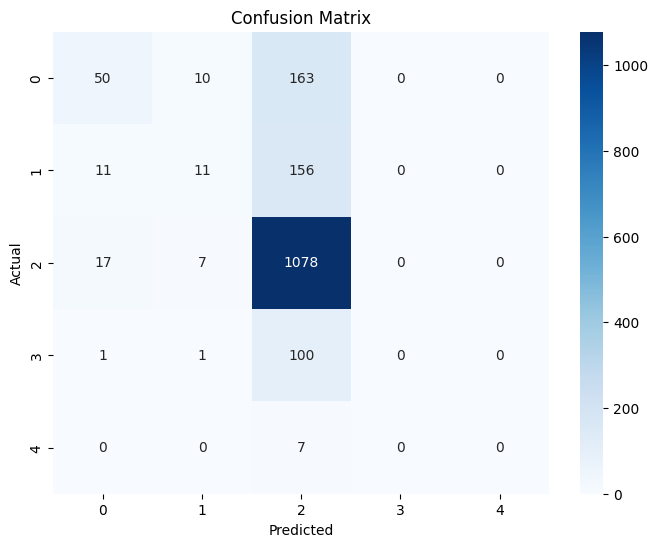

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['0', '1', '2', '3', '4']
cm_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


- **Best performance: 1 epoch, test accuracy: 0.7066, test AUC: 0.7059 (36 mins)**

- Compare with few-shot learning, prompt-tuning drastically improve the performance on test set (+0.40).


---
### Comparasion of different configurations

|                     | Acc           | Auc   | Training Time        |
|---------------------|---------------|-------|----------------------|
| Zero-shot           | 12.03         |       |                      |
| Few-shot (3 epochs) | 56.76 (+44.73)         | 69.10 | 6 mins for 10 epochs |
| Full-data (1 epoch) | 70.66 (+13.9) | 70.59 (+1.49) | 36 mins for 3 epochs |

- AUC: the average AUC of all possible pairwise combinations of classes (one-vs-one, insensitive to class imbalance)
- Few-shot prompt tuning has a drastic improvement in accuracy compare to zero-shot, and full-data prompt tuning improve the performance even more.
- Few-shot prompt tuning is much faster than full-data training and could yield comparable AUC score.
- Advantage: prompt tuning is an efficient way of providing PLM with additional context, which helps it perform better. Soft prompt and soft verbalizer, learned in an automatic fashion, are more efficient than manually defined ones.
- Disadvantage: soft tokens in the template and soft verbalizer are lack of interpretability.

#2. RoBerta Fine-Tuning


## Preprocessing

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
from datasets import load_dataset
adept = load_dataset('json', data_files={
    'train':f'{BASE_DIR}/{TRAIN_FN}',
    'dev': f'{BASE_DIR}/{DEV_FN}',
    'test': f'{BASE_DIR}/{TEST_FN}'})

In [ ]:
def tokenize(examples):
  return tokenizer(examples['sentence1'], examples['sentence2'], truncation=True,
              padding='max_length', max_length=MAX_LEN, return_tensors="pt")

In [ ]:
tokenized_datasets = adept.map(tokenize, batched=True)

Map:   0%|          | 0/12892 [00:00<?, ? examples/s]

Map:   0%|          | 0/1611 [00:00<?, ? examples/s]

Map:   0%|          | 0/1612 [00:00<?, ? examples/s]

In [ ]:
updated_datasets = tokenized_datasets.map(
    lambda example: {'labels': example['label']},
    remove_columns=['label', 'noun', 'modifier'])

Map:   0%|          | 0/12892 [00:00<?, ? examples/s]

Map:   0%|          | 0/1611 [00:00<?, ? examples/s]

Map:   0%|          | 0/1612 [00:00<?, ? examples/s]

In [ ]:
# convert 'input_ids', 'attention_mask', 'labels' to tensors
updated_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Define Training Arguments

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, TrainingArguments, Trainer

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

training_args = TrainingArguments(
    output_dir="roberta-ft",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=TRAIN_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
import torch.nn.functional as F

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=updated_datasets['train'],
    eval_dataset=updated_datasets['dev'],
    compute_metrics=compute_metrics,
)

## Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.884900,0.911122,0.705773
2,0.840600,0.911052,0.704531
3,0.734200,1.001674,0.703290


TrainOutput(global_step=9669, training_loss=0.8243076609707086, metrics={'train_runtime': 2159.7294, 'train_samples_per_second': 17.908, 'train_steps_per_second': 4.477, 'total_flos': 5088178638968832.0, 'train_loss': 0.8243076609707086, 'epoch': 3.0})

In [ ]:
trainer.save_model("./roberta-adept-ft")

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub("melodyzen168/roberta-adept-ft")

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

events.out.tfevents.1705073174.23e8b12646c4.453.0:   0%|          | 0.00/8.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/melodyzen168/roberta-ft/commit/f63f743aba01f2bfc7b2b839ec2af5ee95a14b23', commit_message='melodyzen168/roberta-adept-ft', commit_description='', oid='f63f743aba01f2bfc7b2b839ec2af5ee95a14b23', pr_url=None, pr_revision=None, pr_num=None)

train for 3 epochs, 36mins

## Evaluate on The Test Dataset


Load the model from the huggingface model hub.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("melodyzen168/roberta-ft")

Define evaluate function

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import torch.nn.functional as F

trainer = Trainer(model=model)

def evaluate_with_multi_metrics(trainer, testset):
  # trainer.predict() will return a tuple: predictions (logits), label_ids, metrics
  preds = trainer.predict(testset)
  alllabels = preds.label_ids
  allpreds = np.argmax(preds.predictions, axis = -1)
  logits = preds.predictions
  # logits are nparrays so have to convert them to Pytorh tensor
  logits_tensor = torch.from_numpy(logits)
  outputs = F.softmax(logits_tensor, dim = -1) # Apply softmax to convert logits to probabilities
  allpreds_prob = outputs.numpy() # convert back to nparray

  acc = accuracy_score(alllabels, allpreds)
  # computes the average AUC of all possible pairwise combinations of classes (one-vs-one, insensitive to class imbalance)
  auc = roc_auc_score(alllabels, allpreds_prob, multi_class='ovo', average='macro', labels=list(set(alllabels)))
  cm = confusion_matrix(alllabels, allpreds)
  return acc, auc, cm

In [ ]:
acc, auc, cm = evaluate_with_multi_metrics(trainer, updated_datasets['test'])

Accuracy of Test Data: 0.7295285359801489
AUC of Test Data: 0.7243489378916884


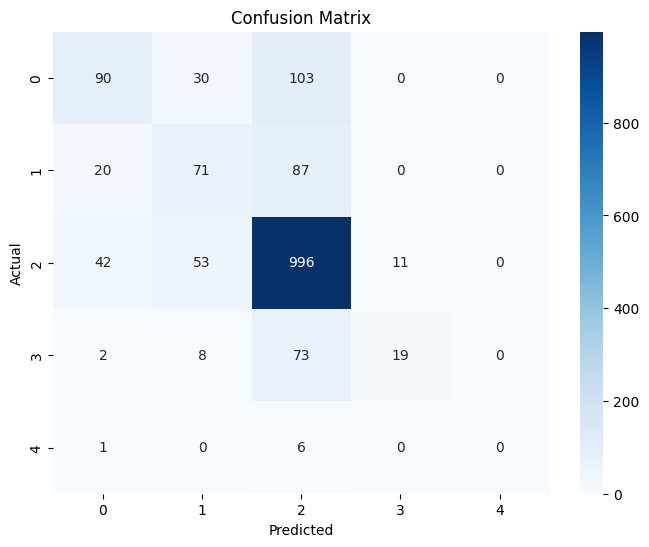

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of Test Data:', acc)
print(f'AUC of Test Data:', auc)

class_labels = ['0', '1', '2', '3', '4']
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()